In [1]:
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df["patient_id"] = df["patient_id"].astype("int")
df["lead_id"] = df["lead_id"].astype("int")

In [4]:
df.head(5)

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio
0,0,1,-0.054317,377.083333,-3297.249202,5756.845777,57.000000,0.404318,3.122865,8.642640,8564.971669,913.046274,0.159116,1.007608,1.011732
1,0,2,0.173118,377.166667,9.640745,2769.939236,57.692308,0.441143,1.907872,2.284969,1435.067840,444.574330,0.159081,0.876788,0.744761
2,0,3,0.803948,411.090909,3226.989388,861.597898,46.833333,0.373397,5.337444,0.085836,-1520.994131,447.789323,0.145953,0.959859,0.946903
3,0,4,0.763358,383.000000,2931.324322,2988.418158,66.461538,0.271741,8.208612,0.346546,48.321557,401.243304,0.156658,1.140411,1.100461
4,0,5,-0.058833,411.272727,-3019.002055,4359.392590,43.916667,0.360466,2.422612,9.218017,8780.695173,786.025130,0.145889,1.045801,0.947137


In [5]:
df = df[["patient_id","lead_id","pr_ratio", "rr_distance", "edr_time_ratio", "edr_energy_ratio"]]
df.head()

,patient_id,lead_id,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio
0,0,1,-0.054317,377.083333,1.007608,1.011732
1,0,2,0.173118,377.166667,0.876788,0.744761
2,0,3,0.803948,411.090909,0.959859,0.946903
3,0,4,0.763358,383.000000,1.140411,1.100461
4,0,5,-0.058833,411.272727,1.045801,0.947137


In [6]:
5# we have 2164 patients
# 20% of 2164 is approximately equals to 433 patients
# randomly generating 433 patients
import random
all_patients = list(range(0, 2164))
selected_patients = random.sample(all_patients, 433)

In [7]:
folder_path = "/content/drive/MyDrive/DIS_Dr_Liu/"
small_X_path = folder_path + "small_X.npy"
small_y_path = folder_path + "small_y.npy"
ecg_X = np.load(small_X_path, allow_pickle=True)
ecg_y = np.load(small_y_path, allow_pickle=True)

print('X: ', ecg_X.shape)
print('y: ', ecg_y.shape)

print(ecg_X[0])
print(ecg_y[0])

X:  (2164, 12, 5000)
y:  (2164,)
[[  10   15   -5 ... -107  -88  -39]
 [ -20   -5  -20 ... -122 -112  -63]
 [ -30  -20  -15 ...  -15  -24  -24]
 ...
 [  34   29   49 ...  137  127   83]
 [ -29  -34  -10 ...   83   73   20]
 [ -39  -59  -34 ...  142  122   39]]
1


In [8]:
y = ecg_y
target_df = pd.DataFrame()
target_df["patient_id"] = all_patients
target_df["target"] = y
target_df["patient_id"] = target_df["patient_id"].astype("int")
target_df["target"] = target_df["target"].astype("int")

In [9]:
merged_df = pd.merge(df, target_df, on='patient_id', how='inner')

In [10]:
merged_df.isna().sum()

patient_id             0
lead_id                0
pr_ratio             520
rr_distance          474
edr_time_ratio      2936
edr_energy_ratio    2936
target                 0
dtype: int64

In [11]:
merged_df.dropna(inplace=True)
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio,target
0,0,1,-0.054317,377.083333,1.007608,1.011732,1
1,0,2,0.173118,377.166667,0.876788,0.744761,1
2,0,3,0.803948,411.090909,0.959859,0.946903,1
3,0,4,0.763358,383.000000,1.140411,1.100461,1
4,0,5,-0.058833,411.272727,1.045801,0.947137,1
...,...,...,...,...,...,...,...
25963,2163,8,0.488058,455.800000,0.953257,0.937737,0
25964,2163,9,-0.016470,471.625000,1.879499,1.736153,0
25965,2163,10,0.477778,428.800000,1.033777,1.018536,0
25966,2163,11,-0.089861,428.500000,1.602314,1.578354,0


In [12]:
merged_df.to_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features_merged.csv")

# Models on all data using Standard Normalization

In [13]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# merged_df.dropna(inplace=True)

In [14]:
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio,target
0,0,1,-0.054317,377.083333,1.007608,1.011732,1
1,0,2,0.173118,377.166667,0.876788,0.744761,1
2,0,3,0.803948,411.090909,0.959859,0.946903,1
3,0,4,0.763358,383.000000,1.140411,1.100461,1
4,0,5,-0.058833,411.272727,1.045801,0.947137,1
...,...,...,...,...,...,...,...
25963,2163,8,0.488058,455.800000,0.953257,0.937737,0
25964,2163,9,-0.016470,471.625000,1.879499,1.736153,0
25965,2163,10,0.477778,428.800000,1.033777,1.018536,0
25966,2163,11,-0.089861,428.500000,1.602314,1.578354,0


In [15]:
merged_df["target"].value_counts()

0    11610
1    11422
Name: target, dtype: int64

In [16]:
# merged_df = merged_df[merged_df["lead_id"] == 1]
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

X = merged_df.drop(["patient_id", "lead_id", "target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio
0,-0.053437,-0.362100,0.043416,0.050114
1,-0.009179,0.623780,-0.196381,-0.191340
2,-0.053662,2.315853,-0.436338,-0.434402
3,-0.059227,2.404195,0.404784,0.346119
4,0.085285,0.885778,-0.283698,-0.290067
...,...,...,...,...
23027,-0.035218,-0.707650,-0.309900,-0.292205
23028,-0.028837,1.638221,0.954743,0.652661
23029,-0.071466,-0.570368,-0.084045,-0.100489
23030,-0.018375,0.907612,-0.111701,-0.160536


# K-Fold

In [17]:
from sklearn.model_selection import cross_val_score, train_test_split

## Training and Testing on Complete Data

In [18]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
len(X_train), len(X_test)

(18425, 4607)

In [20]:
y.value_counts()

0    11610
1    11422
Name: target, dtype: int64

## Logistic Regression

In [21]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.52537313 0.51668928 0.52998643 0.53134328 0.52835821]
Mean CV Accuracy: 0.5264


In [22]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5404818754069893
F1 Score: 0.5102937774693499
Precision: 0.5406862745098039
Recall: 0.48313622426631625


## Decision Trees

In [23]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.62279512 0.6119403  0.62143826 0.62469471 0.61166893]
Mean CV Accuracy: 0.6185


In [24]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6498806164532234
F1 Score: 0.6465044926583388
Precision: 0.6469298245614035
Recall: 0.6460797196671046


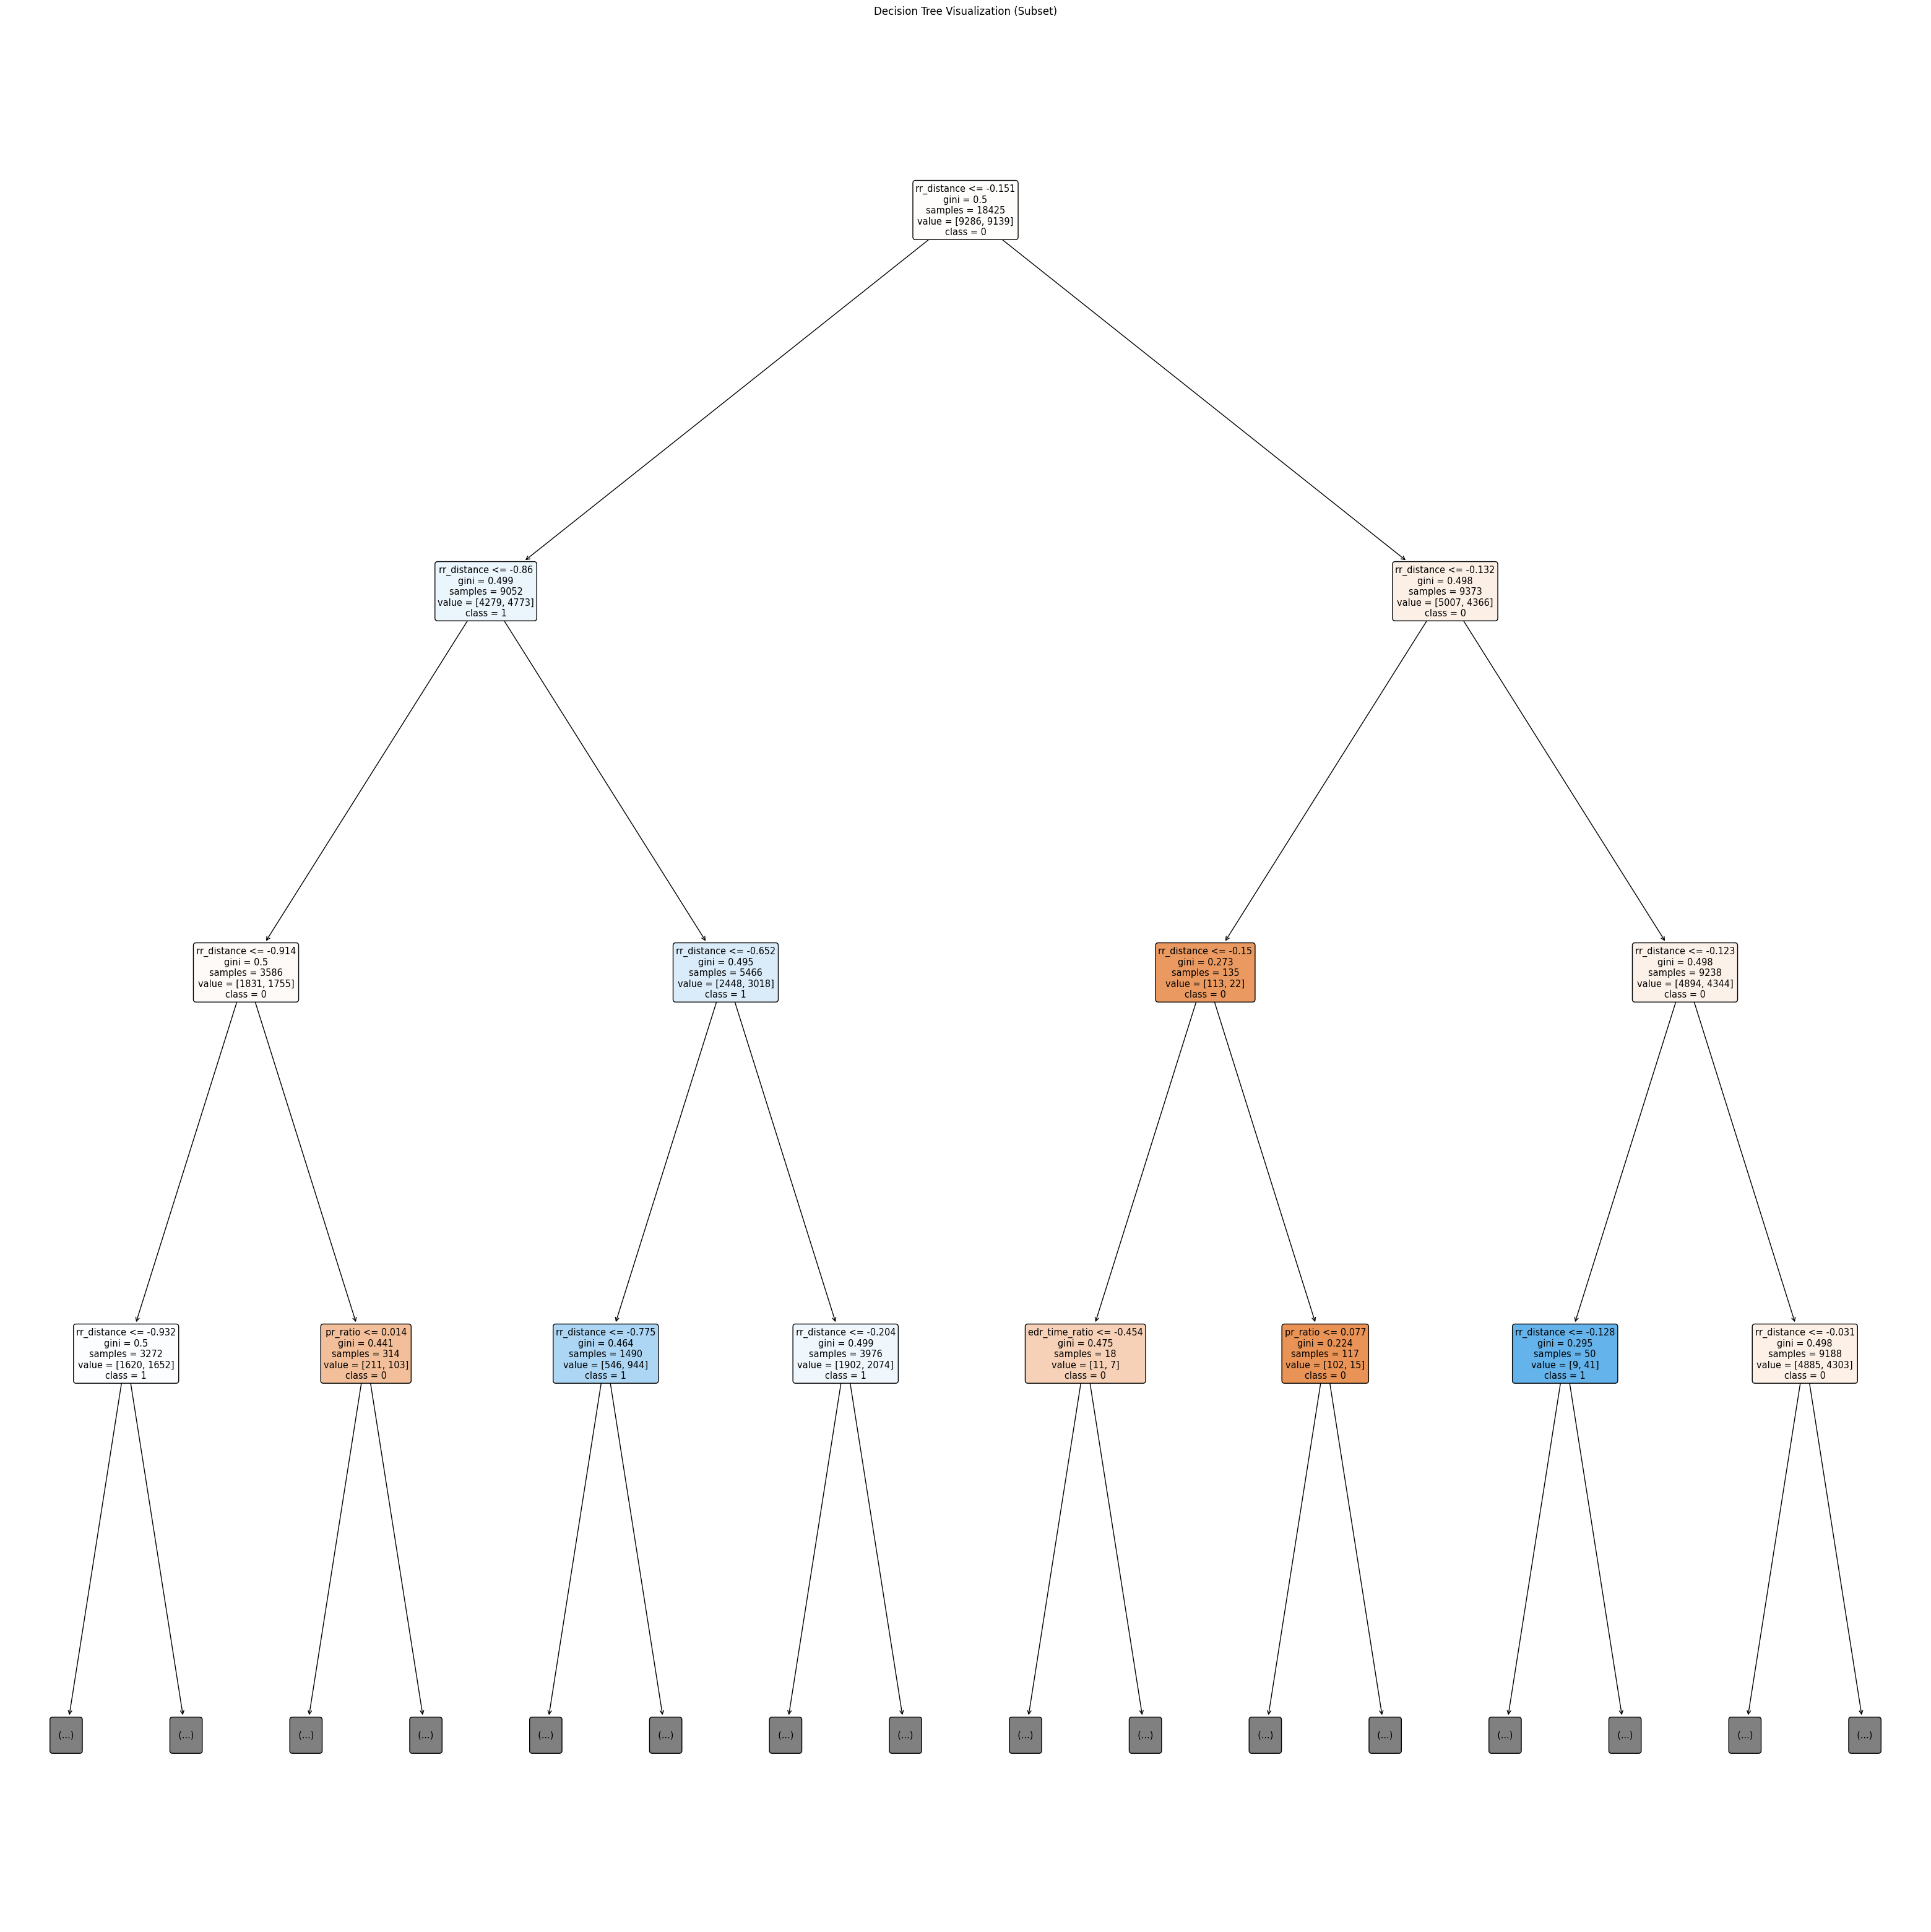

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [26]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.58833107 0.585346   0.59755767 0.59240163 0.5807327 ]
Mean CV Accuracy: 0.5889


In [27]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6019101367484263
F1 Score: 0.5854430379746834
Precision: 0.6048575432041102
Recall: 0.5672360928602715


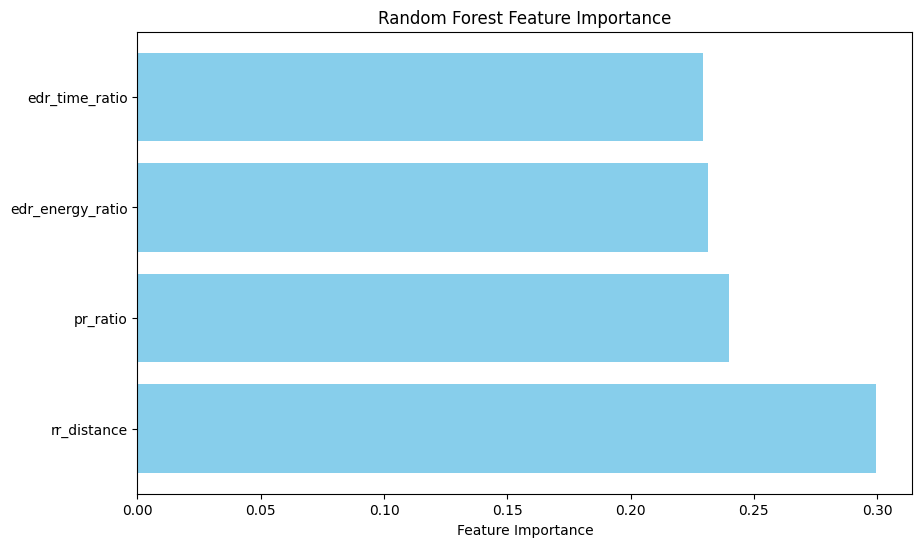

In [28]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [29]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.57720488 0.58046133 0.5834464  0.57259159 0.57693351]
Mean CV Accuracy: 0.5781


In [30]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5836770132407206
F1 Score: 0.5687949640287769
Precision: 0.5842956120092379
Recall: 0.554095488392466


## SVM

In [31]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.53161465 0.52103121 0.52238806 0.52781547 0.52781547]
Mean CV Accuracy: 0.5261


In [32]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.5352724115476449
F1 Score: 0.5410503751339764
Precision: 0.5298068849706129
Recall: 0.5527814279456855


## Naive Bayes

In [33]:
# Create Naive Bayes model
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

Cross-Validation Scores: [0.49715061 0.50529172 0.5009498  0.49606513 0.49606513]
Mean CV Accuracy: 0.4991


In [34]:
# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Naive Bayes Accuracy: 0.49620143260256133
Naive Bayes F1 Score: 0.6601259335188168
Naive Bayes Precision: 0.4958205015398152
Naive Bayes Recall: 0.9872974156811213


## KNN

In [35]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.53704206 0.52727273 0.53405699 0.5394844  0.52537313]
Mean CV Accuracy: 0.5326
KNN Accuracy: 0.5376600824831778
KNN F1 Score: 0.5283436669619133
KNN Precision: 0.5342588446036722
KNN Recall: 0.5225580376697329


# Models on only Lead 1 using Standard Normalization

In [36]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/Datasets/downsampled_feature_labels.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# merged_df.dropna(inplace=True)

In [37]:
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio,target
0,375,12,0.009545,406.818182,1.276771,1.253436,1
1,951,3,0.170827,492.111111,1.024627,1.017721,1
2,684,2,0.008724,638.500000,0.772315,0.780437,1
3,1626,12,-0.011556,646.142857,1.656746,1.542405,0
4,697,9,0.515062,514.777778,0.932814,0.921341,1
...,...,...,...,...,...,...,...
23027,825,3,0.075937,376.923077,0.905263,0.919254,1
23028,769,5,0.099188,579.875000,2.235023,1.841660,1
23029,471,10,-0.056154,388.800000,1.142747,1.106413,1
23030,68,3,0.137313,516.666667,1.113667,1.047793,1


In [38]:
merged_df["target"].value_counts()

0    11610
1    11422
Name: target, dtype: int64

In [39]:
merged_df = merged_df[merged_df["lead_id"] == 1]
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

X = merged_df.drop(["patient_id", "lead_id", "target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio
0,-0.357418,0.435727,-0.674519,-0.707538
1,-0.474082,0.379743,0.349847,-0.176491
2,2.434717,-0.389431,1.475588,1.667016
3,0.351191,-0.600670,0.780462,0.682485
4,-0.107055,0.531037,0.741299,0.956757
...,...,...,...,...
1949,-0.083215,-0.844986,-0.022662,0.006570
1950,1.306956,-0.819147,-0.238216,-0.269411
1951,-0.558672,0.623383,1.556550,1.170974
1952,0.352932,2.020851,-0.295190,-0.205733


# K-Fold

In [40]:
from sklearn.model_selection import cross_val_score, train_test_split

## Training and Testing on Complete Data

In [41]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
len(X_train), len(X_test)

(1563, 391)

In [43]:
y.value_counts()

0    983
1    971
Name: target, dtype: int64

## Logistic Regression

In [44]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.48242812 0.46964856 0.53035144 0.51923077 0.55448718]
Mean CV Accuracy: 0.5112


In [45]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5370843989769821
F1 Score: 0.4958217270194986
Precision: 0.5297619047619048
Recall: 0.46596858638743455


## Decision Trees

In [46]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.48242812 0.53674121 0.55271565 0.48076923 0.5224359 ]
Mean CV Accuracy: 0.5150


In [47]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.49104859335038364
F1 Score: 0.5110565110565111
Precision: 0.48148148148148145
Recall: 0.5445026178010471


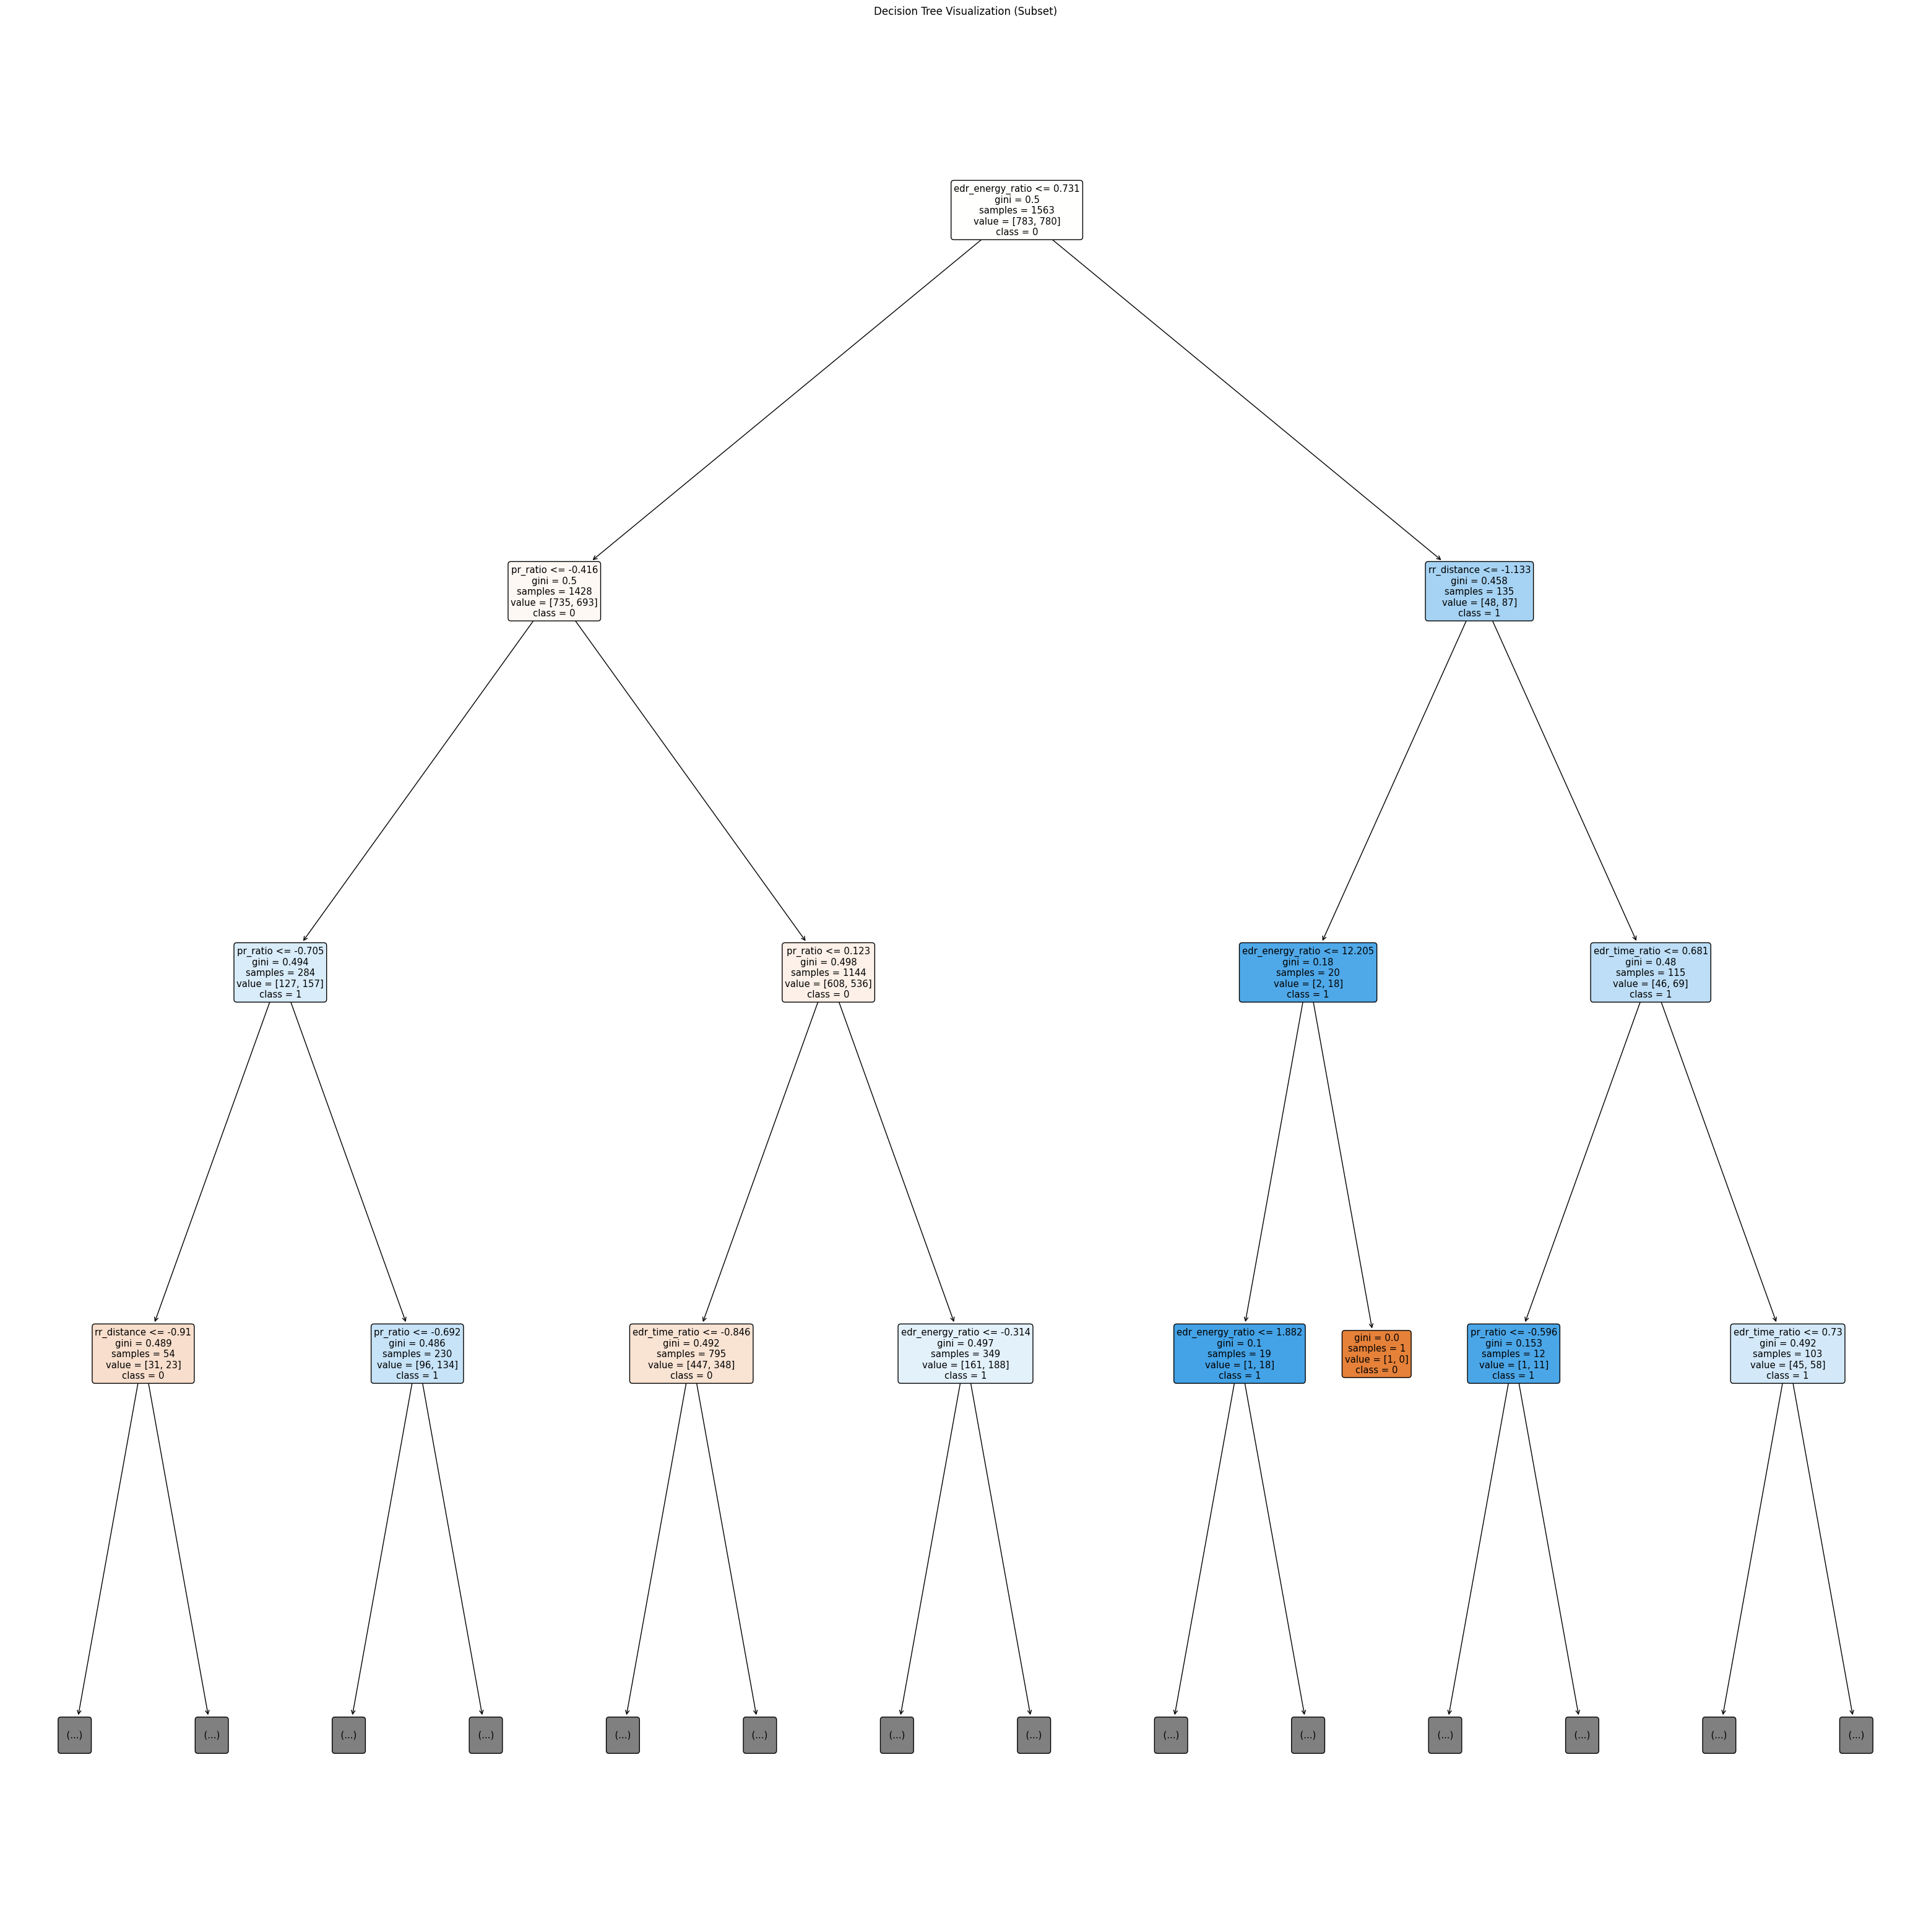

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [49]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.53035144 0.52715655 0.53674121 0.49679487 0.51602564]
Mean CV Accuracy: 0.5214


In [50]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5191815856777494
F1 Score: 0.5228426395939086
Precision: 0.5073891625615764
Recall: 0.5392670157068062


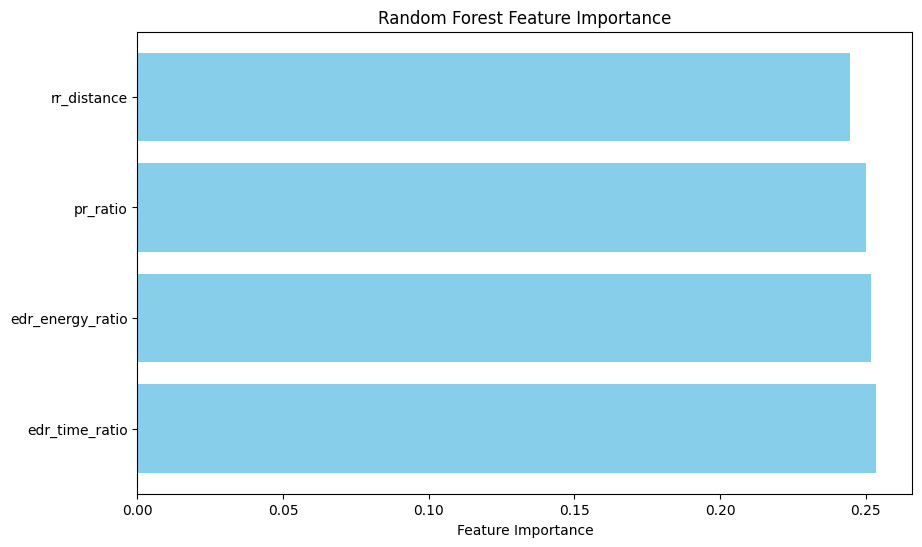

In [51]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [52]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.53354633 0.55591054 0.55591054 0.51923077 0.53525641]
Mean CV Accuracy: 0.5400


In [53]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5012787723785166
F1 Score: 0.520884520884521
Precision: 0.49074074074074076
Recall: 0.5549738219895288


## SVM

In [54]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.485623   0.50798722 0.49201278 0.53205128 0.50641026]
Mean CV Accuracy: 0.5048


In [55]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.49872122762148335
F1 Score: 0.2898550724637681
Precision: 0.47058823529411764
Recall: 0.2094240837696335


## Naive Bayes

In [56]:
# Create Naive Bayes model
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

Cross-Validation Scores: [0.51757188 0.50479233 0.514377   0.53525641 0.53525641]
Mean CV Accuracy: 0.5215


In [57]:
# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Naive Bayes Accuracy: 0.5089514066496164
Naive Bayes F1 Score: 0.16521739130434782
Naive Bayes Precision: 0.48717948717948717
Naive Bayes Recall: 0.09947643979057591


## KNN

In [58]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.50798722 0.50798722 0.50159744 0.49038462 0.49679487]
Mean CV Accuracy: 0.5010
KNN Accuracy: 0.4884910485933504
KNN F1 Score: 0.47643979057591623
KNN Precision: 0.47643979057591623
KNN Recall: 0.47643979057591623


# Models trained on Lead 1+2+3 = 33 features using Standard Normalization

In [59]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/Datasets/downsampled_feature_labels.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# # merged_df.dropna(inplace=True)

In [60]:
merged_df = merged_df[merged_df["lead_id"] < 4]
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio,target
0,2027,1,0.005047,470.444444,0.555015,0.558668,0
1,470,1,-0.016830,465.888889,1.366391,0.936453,1
2,11,1,0.528632,403.300000,2.258065,2.247923,1
3,1195,1,0.137927,386.111111,1.707471,1.547528,0
4,663,1,0.051996,478.200000,1.676451,1.742645,1
...,...,...,...,...,...,...,...
1949,1363,1,0.056466,366.230769,1.071336,1.066683,0
1950,1635,1,0.317153,368.333333,0.900600,0.870350,0
1951,552,1,-0.032692,485.714286,2.322193,1.895039,1
1952,1230,1,0.138253,599.428571,0.855473,0.915651,0


In [61]:
merged_df.columns

Index(['patient_id', 'lead_id', 'pr_ratio', 'rr_distance', 'edr_time_ratio',
       'edr_energy_ratio', 'target'],
      dtype='object')

In [62]:
pivoted_df = merged_df.pivot(index='patient_id', columns='lead_id',\
                             values=['pr_ratio', 'rr_distance', 'edr_time_ratio', 'edr_energy_ratio'])
pivoted_df.sort_index(axis=1, level=1, inplace=True)


In [63]:
pivoted_df

,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance
lead_id,1,1,1,1
patient_id,,,,
0,1.011732,1.007608,-0.054317,377.083333
1,0.786049,0.942913,-0.040611,433.400000
2,1.089178,1.237727,-0.023139,403.250000
3,1.149821,1.001017,0.072957,504.888889
4,0.748991,0.741321,0.076716,536.750000
...,...,...,...,...
2159,0.722308,0.725112,0.034634,426.454545
2160,0.839059,0.805867,0.205243,400.818182


In [64]:
pivoted_df = pivoted_df.reset_index()
pivoted_df

,patient_id,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance
lead_id,,1,1,1,1
0,0,1.011732,1.007608,-0.054317,377.083333
1,1,0.786049,0.942913,-0.040611,433.400000
2,2,1.089178,1.237727,-0.023139,403.250000
3,3,1.149821,1.001017,0.072957,504.888889
4,4,0.748991,0.741321,0.076716,536.750000
...,...,...,...,...,...
1949,2159,0.722308,0.725112,0.034634,426.454545
1950,2160,0.839059,0.805867,0.205243,400.818182
1951,2161,1.142280,1.028140,0.013340,432.100000


In [65]:
merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')

<ipython-input-65-2fe9fba29447>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')


In [66]:
merged_df.dropna(inplace=True)

In [67]:
merged_df.columns

Index([           'patient_id',      ('patient_id', ''),
       ('edr_energy_ratio', 1),   ('edr_time_ratio', 1),
               ('pr_ratio', 1),      ('rr_distance', 1),
                      'target'],
      dtype='object')

In [68]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

merged_df = merged_df.iloc[:,2:]

X = merged_df.drop(["target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,"(edr_energy_ratio, 1)","(edr_time_ratio, 1)","(pr_ratio, 1)","(rr_distance, 1)"
0,-0.211074,-0.328692,-0.037646,0.092310
1,-0.227714,-0.332869,-0.236267,1.036537
2,-0.565158,-0.655163,-0.520483,-0.150683
3,0.374955,0.512207,-0.115427,-0.003212
4,-1.107348,-1.039985,-0.372059,-1.150665
...,...,...,...,...
1949,-1.078376,-0.851245,-0.695667,0.051755
1950,0.270024,0.180088,-0.014924,-0.680892
1951,0.042441,0.029997,-0.355628,-0.420769
1952,0.813243,0.836253,1.372056,1.686846


## Training and Testing on Complete Data

In [69]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
len(X_train), len(X_test)

(1563, 391)

In [71]:
y.value_counts()

0    983
1    971
Name: target, dtype: int64

## Logistic Regression

In [72]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.52715655 0.50798722 0.514377   0.5        0.56089744]
Mean CV Accuracy: 0.5221


In [73]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5166240409207161
F1 Score: 0.5065274151436032
Precision: 0.5078534031413613
Recall: 0.5052083333333334


## Decision Trees

In [74]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.52715655 0.514377   0.50798722 0.46153846 0.51923077]
Mean CV Accuracy: 0.5061


In [75]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4859335038363171
F1 Score: 0.48062015503875966
Precision: 0.47692307692307695
Recall: 0.484375


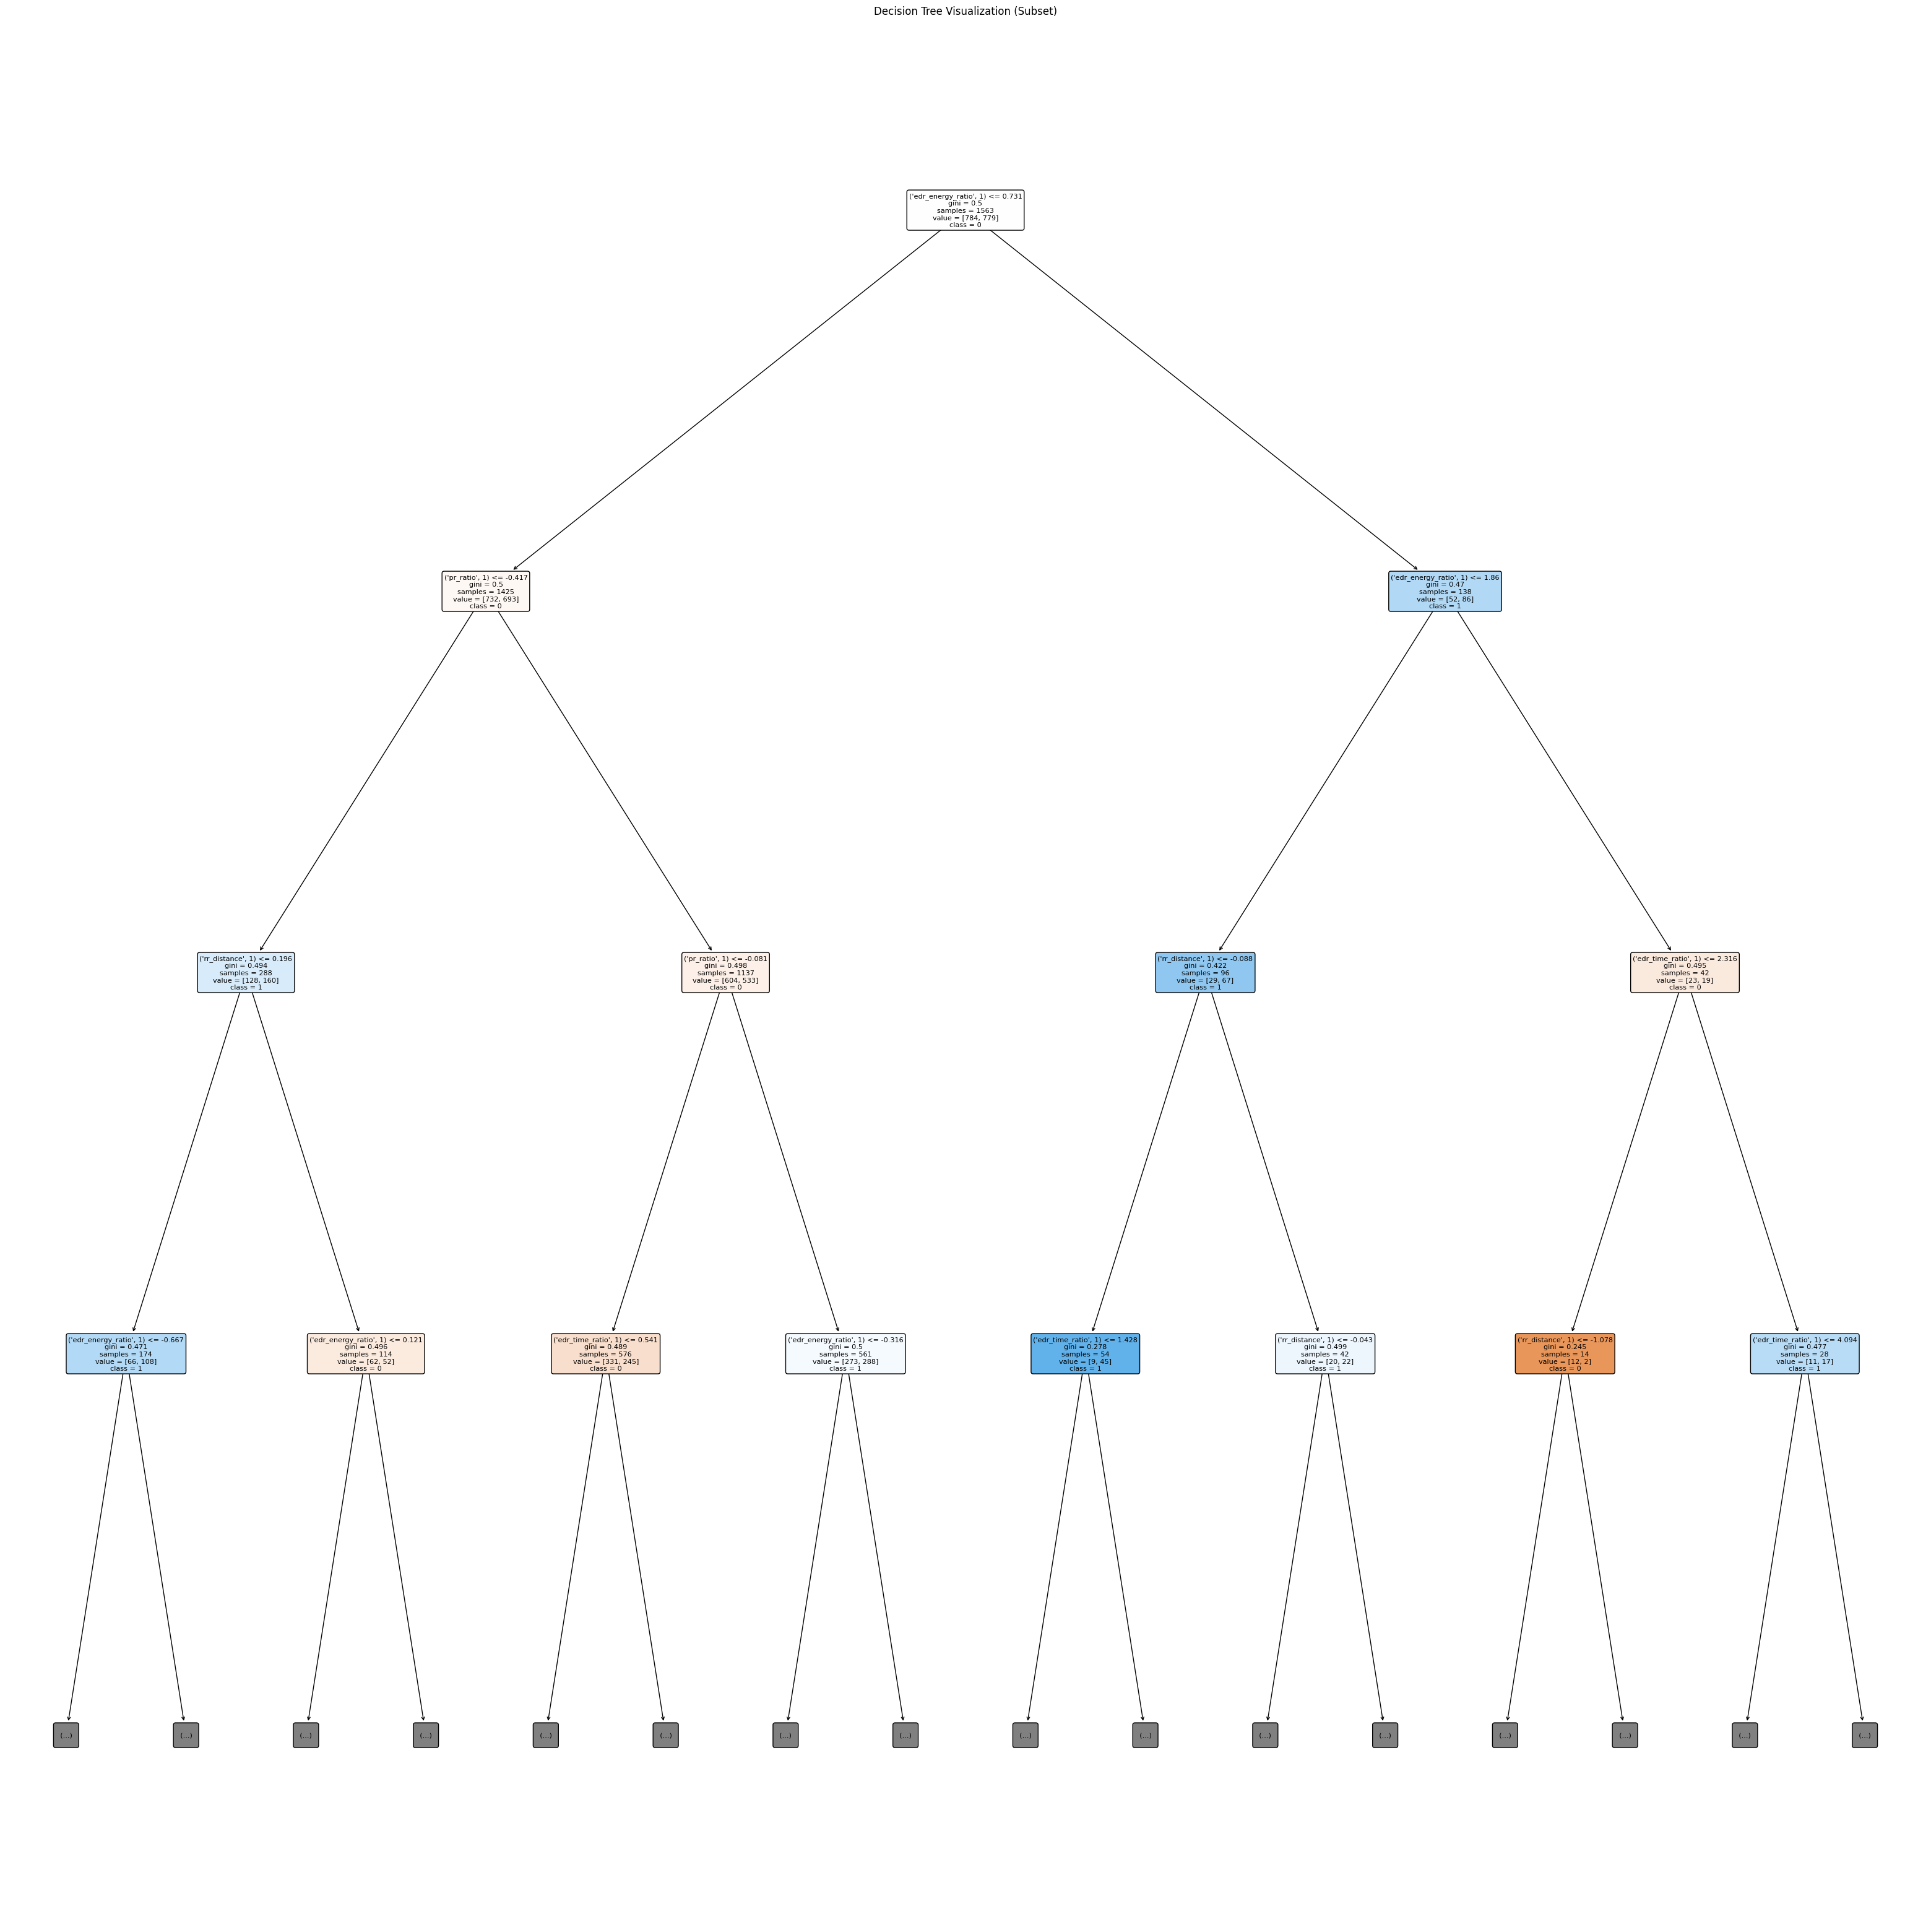

In [76]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [77]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.49840256 0.485623   0.51118211 0.48397436 0.51282051]
Mean CV Accuracy: 0.4984


In [78]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5012787723785166
F1 Score: 0.49350649350649345
Precision: 0.49222797927461137
Recall: 0.4947916666666667


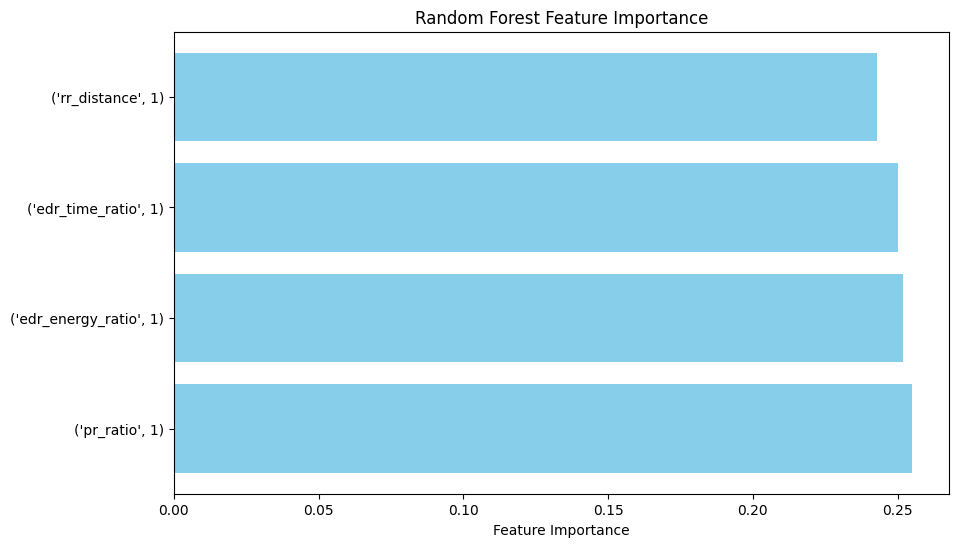

In [79]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [80]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.51118211 0.50798722 0.48881789 0.50961538 0.52564103]
Mean CV Accuracy: 0.5086


In [81]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.48081841432225064
F1 Score: 0.47814910025706947
Precision: 0.4720812182741117
Recall: 0.484375


## SVM

In [82]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.51757188 0.48242812 0.50479233 0.53846154 0.50961538]
Mean CV Accuracy: 0.5106


In [83]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.5268542199488491
F1 Score: 0.4606413994169097
Precision: 0.5231788079470199
Recall: 0.4114583333333333


## Naive Bayes

In [84]:
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Cross-Validation Scores: [0.53354633 0.485623   0.52715655 0.51923077 0.51602564]
Mean CV Accuracy: 0.5163
Naive Bayes Accuracy: 0.5319693094629157
Naive Bayes F1 Score: 0.22127659574468087
Naive Bayes Precision: 0.6046511627906976
Naive Bayes Recall: 0.13541666666666666


## KNN

In [85]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.50159744 0.53035144 0.50479233 0.55448718 0.50641026]
Mean CV Accuracy: 0.5195
KNN Accuracy: 0.4859335038363171
KNN F1 Score: 0.452316076294278
KNN Precision: 0.4742857142857143
KNN Recall: 0.4322916666666667


# Models trained on Lead 1+2+3 ...+12 = 132 features using Standard Normalization

In [86]:
merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features_merged.csv")
merged_df.drop("Unnamed: 0", axis=1, inplace=True)
merged_df.dropna(inplace=True)

In [87]:
# merged_df = merged_df[merged_df["lead_id"] < 4]
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,edr_time_ratio,edr_energy_ratio,target
0,0,1,-0.054317,377.083333,1.007608,1.011732,1
1,0,2,0.173118,377.166667,0.876788,0.744761,1
2,0,3,0.803948,411.090909,0.959859,0.946903,1
3,0,4,0.763358,383.000000,1.140411,1.100461,1
4,0,5,-0.058833,411.272727,1.045801,0.947137,1
...,...,...,...,...,...,...,...
23027,2163,8,0.488058,455.800000,0.953257,0.937737,0
23028,2163,9,-0.016470,471.625000,1.879499,1.736153,0
23029,2163,10,0.477778,428.800000,1.033777,1.018536,0
23030,2163,11,-0.089861,428.500000,1.602314,1.578354,0


In [88]:
merged_df.columns

Index(['patient_id', 'lead_id', 'pr_ratio', 'rr_distance', 'edr_time_ratio',
       'edr_energy_ratio', 'target'],
      dtype='object')

In [89]:
pivoted_df = merged_df.pivot(index='patient_id', columns='lead_id',\
                             values=['pr_ratio', 'rr_distance', 'edr_time_ratio', 'edr_energy_ratio'])
pivoted_df.sort_index(axis=1, level=1, inplace=True)


In [90]:
pivoted_df

,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,...,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance
lead_id,1,1,1,1,2,2,2,2,3,3,...,10,10,11,11,11,11,12,12,12,12
patient_id,,,,,,,,,,,,,,,,,,,,,
0,1.011732,1.007608,-0.054317,377.083333,0.744761,0.876788,0.173118,377.166667,0.946903,0.959859,...,-0.014997,377.083333,0.926015,0.957274,-0.046254,377.083333,0.858680,0.952977,-0.055422,377.166667
1,0.786049,0.942913,-0.040611,433.400000,0.840727,0.959791,-0.116662,433.400000,NaN,NaN,...,-0.098906,433.400000,0.910001,0.937862,-0.079302,433.400000,0.898479,0.964186,-0.060623,433.400000
2,1.089178,1.237727,-0.023139,403.250000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.149821,1.001017,0.072957,504.888889,0.942802,0.910451,0.025433,454.300000,0.847680,0.696311,...,-0.075949,454.400000,1.423961,1.297454,-0.051985,454.400000,1.087794,1.021021,-0.031627,454.400000
4,0.748991,0.741321,0.076716,536.750000,0.891510,0.829132,0.142636,536.750000,2.209482,2.116705,...,0.024419,536.875000,1.341023,1.321160,0.004528,536.875000,1.670057,1.628468,0.012516,536.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,0.722308,0.725112,0.034634,426.454545,1.146189,1.118001,0.042977,420.200000,1.527741,1.374916,...,-0.010485,426.545455,1.804689,1.909613,-0.018247,426.545455,1.137907,1.055215,-0.005981,420.100000
2160,0.839059,0.805867,0.205243,400.818182,0.819114,0.766917,0.111059,400.909091,1.235104,0.987741,...,0.033154,400.909091,1.207580,1.148097,0.026122,400.818182,1.162067,1.101577,0.026281,400.818182


In [91]:
pivoted_df = pivoted_df.reset_index()
pivoted_df

,patient_id,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance,edr_energy_ratio,...,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance,edr_energy_ratio,edr_time_ratio,pr_ratio,rr_distance
lead_id,,1,1,1,1,2,2,2,2,3,...,10,10,11,11,11,11,12,12,12,12
0,0,1.011732,1.007608,-0.054317,377.083333,0.744761,0.876788,0.173118,377.166667,0.946903,...,-0.014997,377.083333,0.926015,0.957274,-0.046254,377.083333,0.858680,0.952977,-0.055422,377.166667
1,1,0.786049,0.942913,-0.040611,433.400000,0.840727,0.959791,-0.116662,433.400000,NaN,...,-0.098906,433.400000,0.910001,0.937862,-0.079302,433.400000,0.898479,0.964186,-0.060623,433.400000
2,2,1.089178,1.237727,-0.023139,403.250000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.149821,1.001017,0.072957,504.888889,0.942802,0.910451,0.025433,454.300000,0.847680,...,-0.075949,454.400000,1.423961,1.297454,-0.051985,454.400000,1.087794,1.021021,-0.031627,454.400000
4,4,0.748991,0.741321,0.076716,536.750000,0.891510,0.829132,0.142636,536.750000,2.209482,...,0.024419,536.875000,1.341023,1.321160,0.004528,536.875000,1.670057,1.628468,0.012516,536.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,2159,0.722308,0.725112,0.034634,426.454545,1.146189,1.118001,0.042977,420.200000,1.527741,...,-0.010485,426.545455,1.804689,1.909613,-0.018247,426.545455,1.137907,1.055215,-0.005981,420.100000
2158,2160,0.839059,0.805867,0.205243,400.818182,0.819114,0.766917,0.111059,400.909091,1.235104,...,0.033154,400.909091,1.207580,1.148097,0.026122,400.818182,1.162067,1.101577,0.026281,400.818182
2159,2161,1.142280,1.028140,0.013340,432.100000,0.926035,0.950140,0.211931,432.181818,0.806989,...,0.151527,432.200000,0.885770,0.917306,0.054565,432.181818,0.997710,0.970053,0.010766,432.222222


In [92]:
merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')

<ipython-input-92-2fe9fba29447>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')


In [93]:
merged_df.dropna(inplace=True)

In [94]:
merged_df.columns

Index([            'patient_id',       ('patient_id', ''),
        ('edr_energy_ratio', 1),    ('edr_time_ratio', 1),
                ('pr_ratio', 1),       ('rr_distance', 1),
        ('edr_energy_ratio', 2),    ('edr_time_ratio', 2),
                ('pr_ratio', 2),       ('rr_distance', 2),
        ('edr_energy_ratio', 3),    ('edr_time_ratio', 3),
                ('pr_ratio', 3),       ('rr_distance', 3),
        ('edr_energy_ratio', 4),    ('edr_time_ratio', 4),
                ('pr_ratio', 4),       ('rr_distance', 4),
        ('edr_energy_ratio', 5),    ('edr_time_ratio', 5),
                ('pr_ratio', 5),       ('rr_distance', 5),
        ('edr_energy_ratio', 6),    ('edr_time_ratio', 6),
                ('pr_ratio', 6),       ('rr_distance', 6),
        ('edr_energy_ratio', 7),    ('edr_time_ratio', 7),
                ('pr_ratio', 7),       ('rr_distance', 7),
        ('edr_energy_ratio', 8),    ('edr_time_ratio', 8),
                ('pr_ratio', 8),       ('rr_distance', 8

In [95]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

merged_df = merged_df.iloc[:,2:]

X = merged_df.drop(["target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,"(edr_energy_ratio, 1)","(edr_time_ratio, 1)","(pr_ratio, 1)","(rr_distance, 1)","(edr_energy_ratio, 2)","(edr_time_ratio, 2)","(pr_ratio, 2)","(rr_distance, 2)","(edr_energy_ratio, 3)","(edr_time_ratio, 3)",...,"(pr_ratio, 10)","(rr_distance, 10)","(edr_energy_ratio, 11)","(edr_time_ratio, 11)","(pr_ratio, 11)","(rr_distance, 11)","(edr_energy_ratio, 12)","(edr_time_ratio, 12)","(pr_ratio, 12)","(rr_distance, 12)"
0,0.142336,0.041695,-0.325591,-0.162019,0.162604,0.089382,0.666810,-0.173465,-0.240117,-0.289726,...,-0.642033,-0.147928,-0.221702,-0.223233,-0.607778,-0.138733,-0.198132,-0.201531,-0.208368,-0.128912
1,-0.347670,-0.414464,-0.248638,0.070553,-0.324426,-0.439009,-0.653603,-0.415256,0.276022,0.234299,...,-0.639971,0.080882,-0.172400,-0.288149,-1.049582,0.094150,1.378303,1.378428,-0.252430,-1.178144
2,0.255468,0.111381,-0.318513,-0.127326,-0.385412,-0.439458,0.103157,-0.140903,-0.062084,-0.049897,...,-0.333749,-0.112532,-0.074363,-0.153248,-0.181107,-0.101420,-0.147506,-0.239540,-0.023531,-0.092975
3,0.414778,0.266368,-0.485373,0.302739,-0.873646,-0.871312,-0.797424,0.247166,-0.130998,-0.192111,...,-0.818833,0.309313,-0.591173,-0.608345,-0.818029,0.326647,-0.147990,-0.170480,-0.609556,0.335317
4,-0.570195,-0.478208,0.001793,2.057855,-0.654559,-0.561049,-0.816228,1.837235,0.235714,0.283083,...,-0.038146,2.037779,-0.542677,-0.425562,0.011411,2.084109,-0.304811,-0.255601,-0.113412,2.090198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,0.184114,0.330763,0.094468,-1.005328,0.235619,0.199225,-0.332725,-1.523700,0.353032,0.309805,...,0.273845,-1.614758,-0.183776,-0.136395,0.795243,-1.630727,0.045497,0.022613,0.844834,-1.617217
1215,0.140477,0.141821,0.246460,-1.172065,0.825240,0.800970,-0.393173,-1.087608,15.506209,16.056323,...,-0.557562,-1.141637,-1.273077,-1.184472,-0.426720,-1.150128,0.608071,0.658996,-0.294893,-1.137807
1216,-0.157401,-0.139648,0.333998,1.478549,-0.341240,-0.301977,1.091931,1.309912,-0.061336,-0.031519,...,0.566690,1.466104,-0.642914,-0.656233,1.158968,1.502455,-0.389511,-0.418929,1.472098,1.509787
1217,-0.751038,-0.693337,-0.049063,-0.078499,-0.463264,-0.500025,-0.595290,-0.097874,-0.174330,-0.203350,...,-0.364001,-0.065759,-0.368427,-0.374166,-0.289134,-0.055101,-0.367866,-0.380809,-0.403613,-0.045487


## Training and Testing on Complete Data

In [96]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
len(X_train), len(X_test)

(975, 244)

In [98]:
y.value_counts()

0    611
1    608
Name: target, dtype: int64

## Logistic Regression

In [99]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.53333333 0.52307692 0.52307692 0.54358974 0.58461538]
Mean CV Accuracy: 0.5415


In [100]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5532786885245902
F1 Score: 0.5514403292181069
Precision: 0.5403225806451613
Recall: 0.5630252100840336


## Decision Trees

In [101]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.50769231 0.47692308 0.50769231 0.53846154 0.58974359]
Mean CV Accuracy: 0.5241


In [102]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5614754098360656
F1 Score: 0.5668016194331984
Precision: 0.546875
Recall: 0.5882352941176471


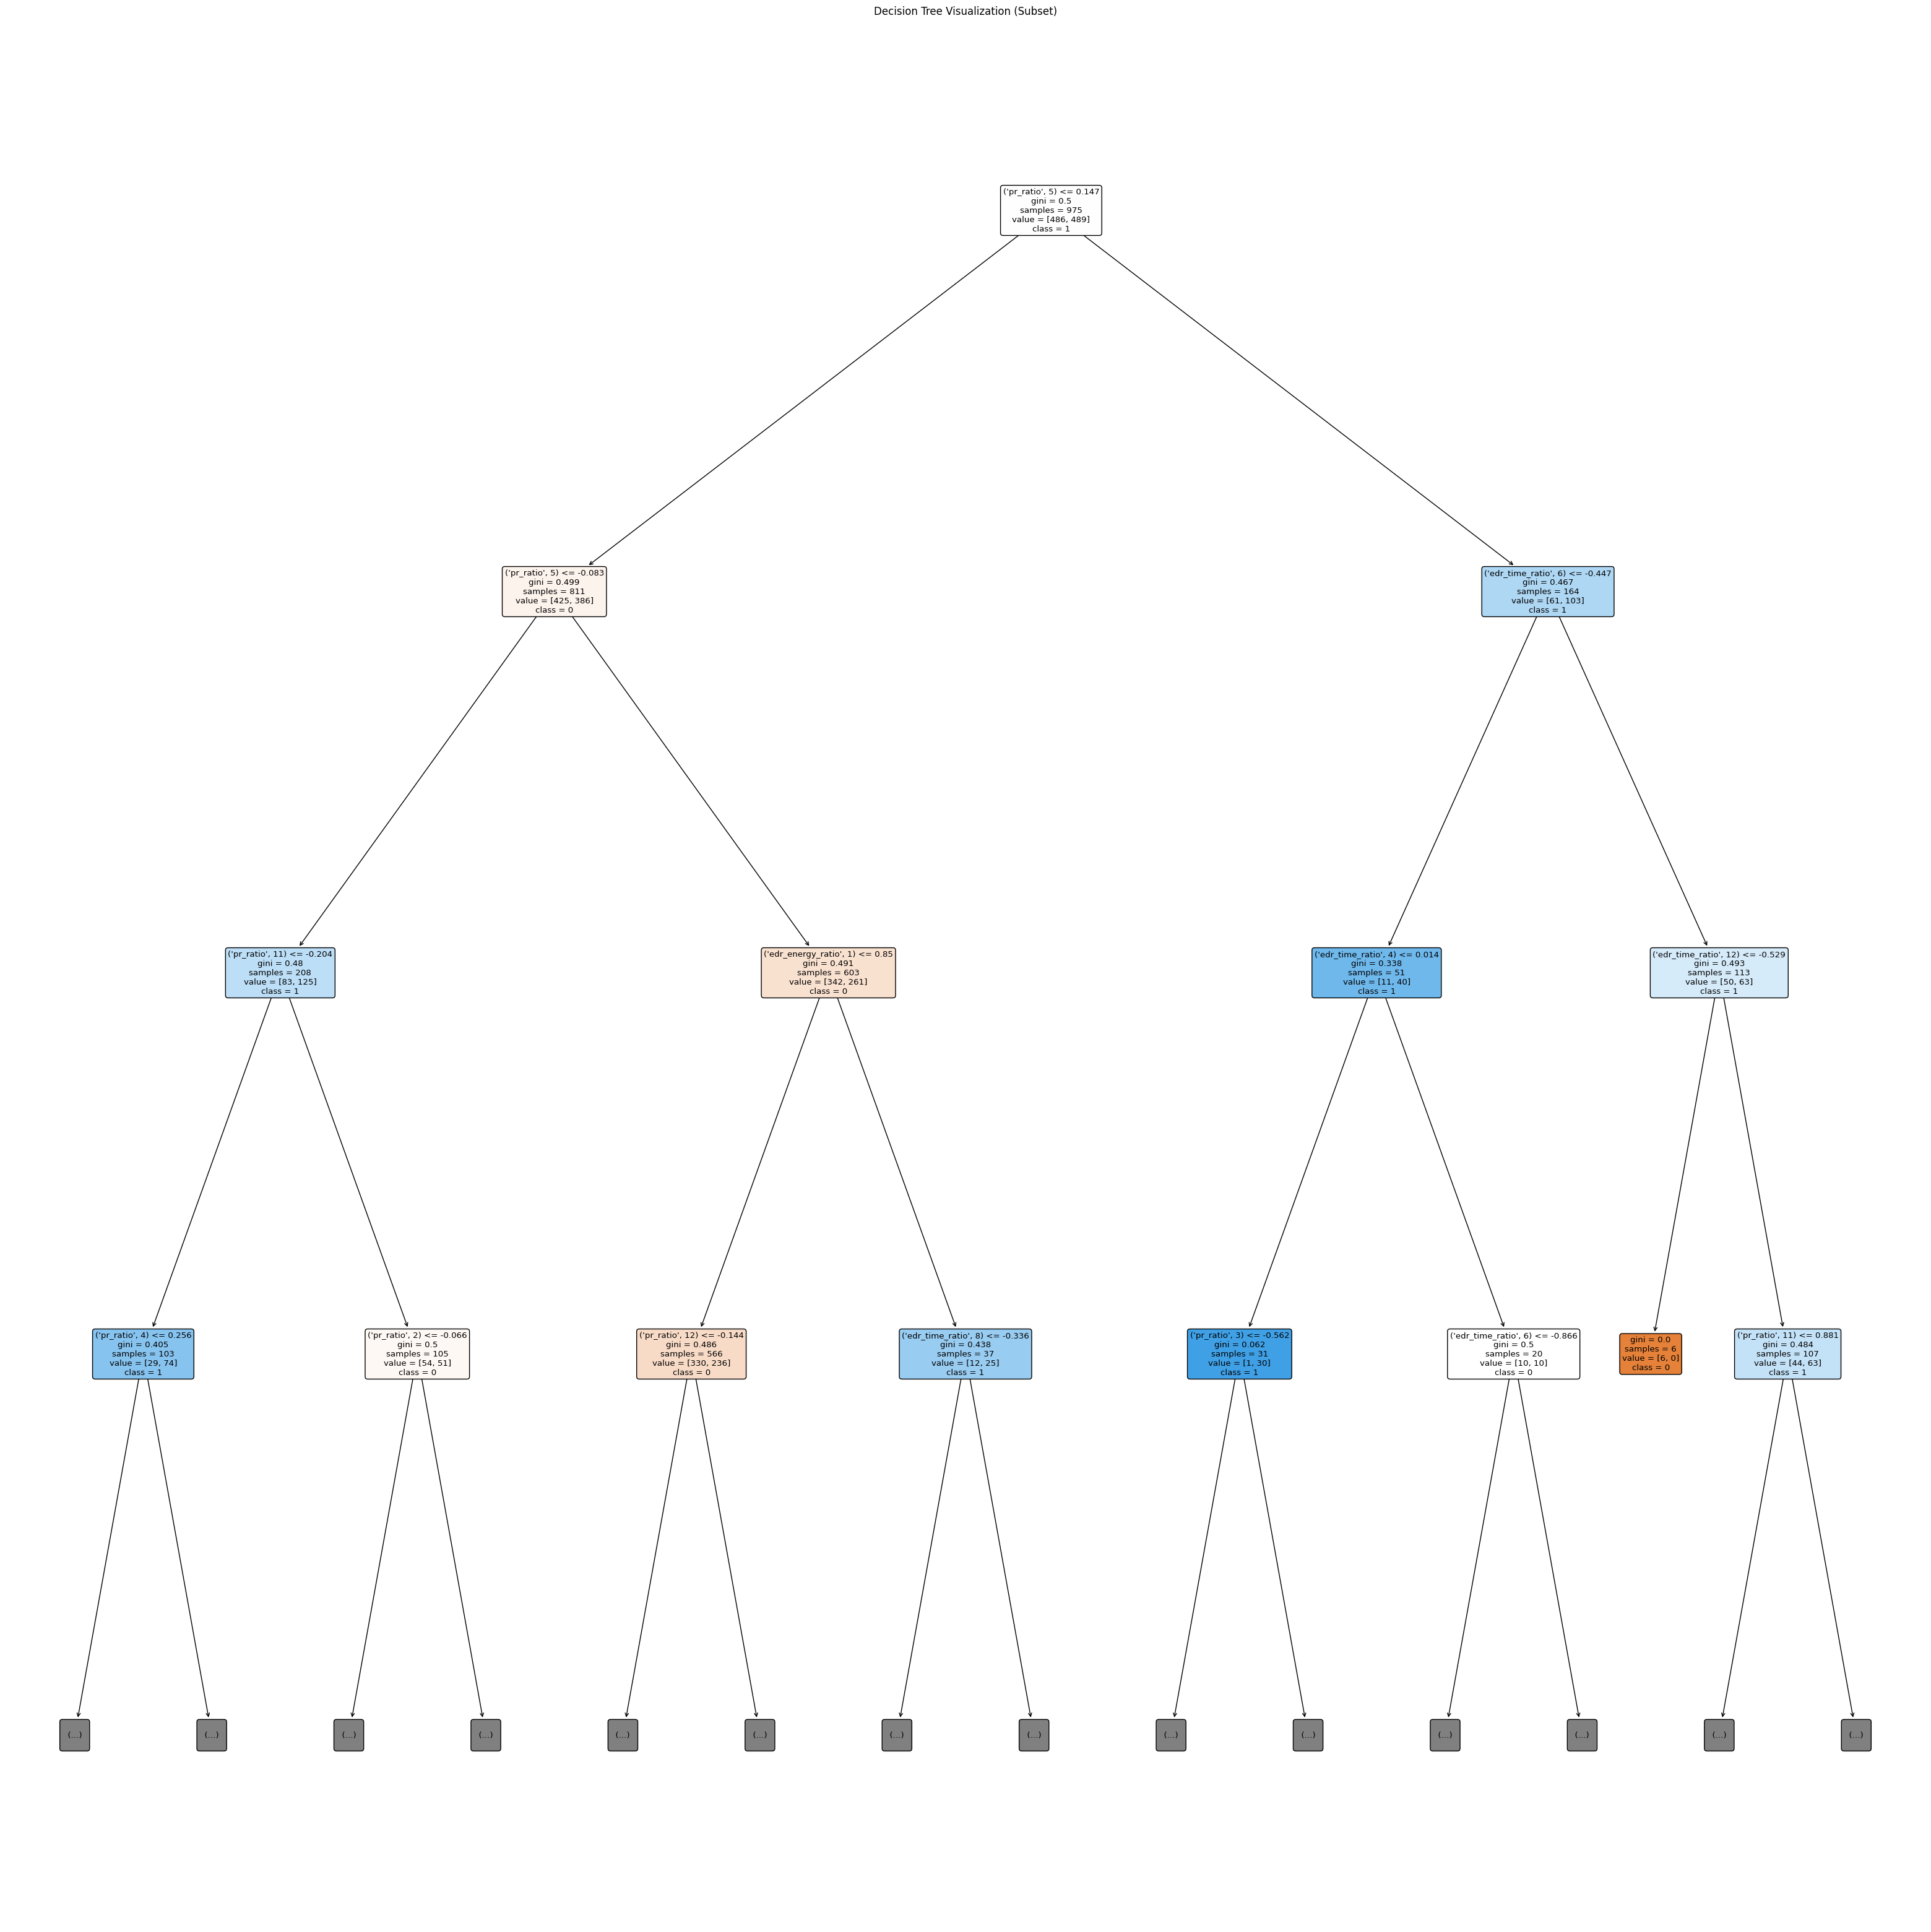

In [103]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [104]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.52307692 0.56923077 0.51794872 0.56410256 0.54871795]
Mean CV Accuracy: 0.5446


In [105]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5573770491803278
F1 Score: 0.5304347826086956
Precision: 0.5495495495495496
Recall: 0.5126050420168067


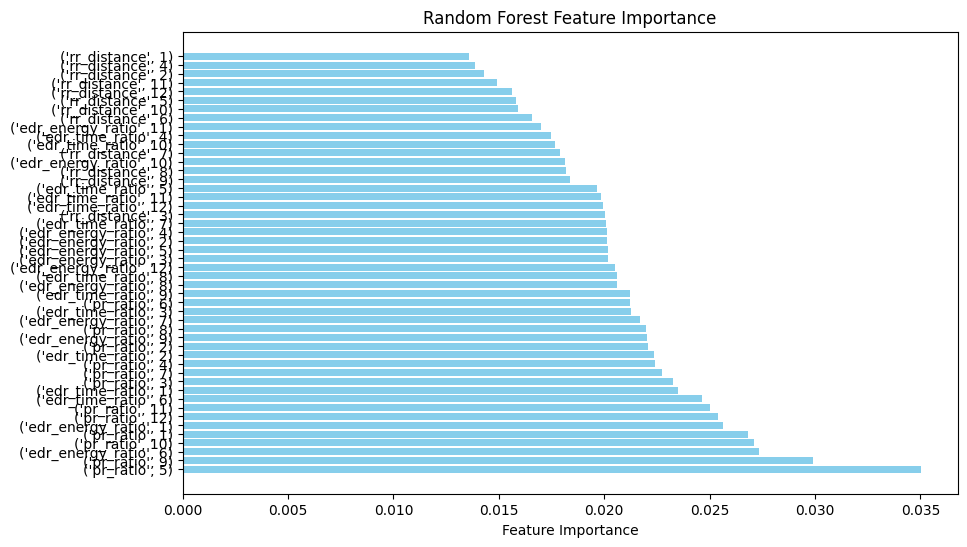

In [106]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [107]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.50769231 0.4974359  0.55384615 0.65128205 0.55384615]
Mean CV Accuracy: 0.5528


In [108]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5491803278688525
F1 Score: 0.52991452991453
Precision: 0.5391304347826087
Recall: 0.5210084033613446


## SVM

In [109]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.52820513 0.48205128 0.57435897 0.55384615 0.54358974]
Mean CV Accuracy: 0.5364


In [110]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.5573770491803278
F1 Score: 0.5645161290322581
Precision: 0.5426356589147286
Recall: 0.5882352941176471


## Naive Bayes

In [111]:
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Cross-Validation Scores: [0.47179487 0.54358974 0.49230769 0.45641026 0.48717949]
Mean CV Accuracy: 0.4903
Naive Bayes Accuracy: 0.46311475409836067
Naive Bayes F1 Score: 0.5814696485623002
Naive Bayes Precision: 0.4690721649484536
Naive Bayes Recall: 0.7647058823529411


## KNN

In [112]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.50769231 0.46666667 0.45128205 0.56410256 0.49230769]
Mean CV Accuracy: 0.4964
KNN Accuracy: 0.5040983606557377
KNN F1 Score: 0.4669603524229075
KNN Precision: 0.49074074074074076
KNN Recall: 0.44537815126050423
